In [2]:
pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 28.4 MB/s 
     |████████████████████████████████| 12.8 MB 57.9 MB/s 
     |████████████████████████████████| 240 kB 83.2 MB/s 
     |████████████████████████████████| 106 kB 67.7 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 37.5 MB 1.1 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
     |████████████████████████████████| 929 kB 58.8 MB/s 
     |████████████████████████████████| 4.0 MB 49.7 MB/s 
     |████████████████████████████████| 1.9 MB 65.5 MB/s 
     |████████████████████████████████| 112 kB 62.9 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.4-py3-none-any.whl size=12274 sha256=622b6797fbbdceb27cfd5353cbb25e6482e1c4dcf0542fe64c6f5b90ba2f88f8
  Stored in directory: /root/.cache/pip/wheels/40/2c/d7/aa0

In [4]:
pip install qiskit-ignis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 35.5 MB/s 


In [8]:
import qiskit
qiskit.IBMQ.save_account('17efde49764005e8eeb00dd065d44bc208778be72d44b475e508d20504818786f842988b0e506515c78debdd1b0c4b570717863db5e4f85569fb43c4c8626b8a', 
                  overwrite = True)
qiskit.IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [99]:
import numpy as np
import math
from qiskit import *
nshots = 8192
IBMQ.load_account()
#provider= qiskit.IBMQ.get_provider(hub='ibm-q-research-2',group='federal-uni-sant-1',project='main')
provider = qiskit.IBMQ.get_provider(hub='ibm-q', group='open', project='main')
device = provider.get_backend('ibmq_quito')
simulator = Aer.get_backend('qasm_simulator')
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

ibmqfactory.load_account:WARNING:2022-12-20 02:40:22,210: Credentials are already in use. The existing account in the session will be replaced.


In [100]:
def coh_l1(rho):
    d = rho.shape[0]; C = 0
    for j in range(0,d-1):
        for k in range(j+1,d):
            C += np.abs(rho[j,k])
    return 2*C

In [101]:
def predict_jb(rho):
    return abs(rho[0,0]-rho[1,1])

In [102]:
r00 = 2/3; r01 = 1.33/3; r10 = 1.33/3; r11 = 1/3 # initial state
r = math.sqrt((r00-r11)**2 + abs(2*r01)**2) # raio de Bloch
th = math.acos((r00-r11)/r)
ph = math.acos(2*r01.real/(r*math.sin(th))) # angulos de Bloch
r0 = (1+r)/2.; r1 = (1-r)/2. # autovetores
print(r, th, ph, r0, r1)

0.9472533393390012 1.2112019334816335 1.4901161193847656e-08 0.9736266696695006 0.026373330330499378


In [117]:
# simulation
p = np.arange(0,1.1,0.1)
d = len(p)
Csim = np.zeros(d); Psim = np.zeros(d)

for j in range(0,d):
    pI = (4-3*p[j])/4; pX = p[j]/4; pZ = p[j]/4; pY = p[j]/4 # depolarizing
    # sequencia: 0000 0001 0010 0011 0100 0101 0110 0111 1000 1001 1010 1011 1100 1101 1110 1111  
    #           = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    Phi_ABCD = [math.sqrt(r0*pI)*math.cos(th/2), 
                math.sqrt(r0*pX)*(math.cos(ph)+1j*math.sin(ph))*math.sin(th/2), 
                math.sqrt(r0*pZ)*math.cos(th/2), 
                -1j*math.sqrt(r0*pY)*(math.cos(ph)+1j*math.sin(ph))*math.sin(th/2), 
                math.sqrt(r1*pI)*math.sin(th/2), 
                -math.sqrt(r1*pX)*(math.cos(ph)+1j*math.sin(ph))*math.cos(th/2), 
                math.sqrt(r1*pZ)*math.sin(th/2), 
                1j*math.sqrt(r1*pY)*(math.cos(ph)+1j*math.sin(ph))*math.cos(th/2), 
                math.sqrt(r0*pI)*(math.cos(ph)+1j*math.sin(ph))*math.sin(th/2), 
                math.sqrt(r0*pX)*math.cos(th/2), 
                -math.sqrt(r0*pZ)*(math.cos(ph)+1j*math.sin(ph))*math.sin(th/2), 
                1j*math.sqrt(r0*pY)*math.cos(th/2), 
                -math.sqrt(r1*pI)*(math.cos(ph)+1j*math.sin(ph))*math.cos(th/2), 
                math.sqrt(r1*pX)*math.sin(th/2), 
                math.sqrt(r1*pZ)*(math.cos(ph)+1j*math.sin(ph))*math.cos(th/2), 
                1j*math.sqrt(r1*pY)*math.sin(th/2)]
    qr = QuantumRegister(4) 
    qc = QuantumCircuit(qr)
    qc.initialize(Phi_ABCD, [qr[0],qr[3],qr[2],qr[1]])
    qstc = state_tomography_circuits(qc, [qr[1]])
    job = qiskit.execute(qstc, backend = simulator, shots=nshots)
    qstf = StateTomographyFitter(job.result(), qstc)
    rho_sim = qstf.fit(method='lstsq')
    Csim[j] = coh_l1(rho_sim)
    Psim[j] = predict_jb(rho_sim)

In [104]:
# theoretical
pt = np.arange(0,1.01,0.01) 
Ct = (1-pt)*(2*1.33/3)
Pt = (1-pt)*(1/3)

In [105]:
# experiment
p = np.arange(0,1.1,0.1); d = len(p)
Cexp = np.zeros(d); Pexp = np.zeros(d)
jobs_ids = []

for j in range(0,d):
    pI = (4-3*p[j])/4; pX = p[j]/4; pZ = p[j]/4; pY = p[j]/4
    Phi_ABCD = [math.sqrt(r0*pI)*math.cos(th/2), 
                math.sqrt(r0*pX)*(math.cos(ph)+1j*math.sin(ph))*math.sin(th/2), 
                math.sqrt(r0*pZ)*math.cos(th/2), 
                -1j*math.sqrt(r0*pY)*(math.cos(ph)+1j*math.sin(ph))*math.sin(th/2), 
                math.sqrt(r1*pI)*math.sin(th/2), 
                -math.sqrt(r1*pX)*(math.cos(ph)+1j*math.sin(ph))*math.cos(th/2), 
                math.sqrt(r1*pZ)*math.sin(th/2), 
                1j*math.sqrt(r1*pY)*(math.cos(ph)+1j*math.sin(ph))*math.cos(th/2), 
                math.sqrt(r0*pI)*(math.cos(ph)+1j*math.sin(ph))*math.sin(th/2), 
                math.sqrt(r0*pX)*math.cos(th/2), 
                -math.sqrt(r0*pZ)*(math.cos(ph)+1j*math.sin(ph))*math.sin(th/2), 
                1j*math.sqrt(r0*pY)*math.cos(th/2), 
                -math.sqrt(r1*pI)*(math.cos(ph)+1j*math.sin(ph))*math.cos(th/2), 
                math.sqrt(r1*pX)*math.sin(th/2), 
                math.sqrt(r1*pZ)*(math.cos(ph)+1j*math.sin(ph))*math.cos(th/2), 
                1j*math.sqrt(r1*pY)*math.sin(th/2)]
    qr = QuantumRegister(4); qc = QuantumCircuit(qr)
    qc.initialize(Phi_ABCD, [qr[0],qr[3],qr[2],qr[1]])
    qstc = state_tomography_circuits(qc, [qr[1]])
    job = qiskit.execute(qstc, backend = device, shots=nshots)
    jobs_ids.append(job.job_id())
    print(job.job_id())
    job_monitor(job)
    qstf = StateTomographyFitter(job.result(), qstc)
    rho_exp = qstf.fit(method='lstsq')
    Cexp[j] = coh_l1(rho_exp)
    #Pexp[j] = predict_jb(rho_exp)

63a120f105888eb07f99ab69
Job Status: job has successfully run
63a1213e05888e75e699ab6b
Job Status: job has successfully run
63a12151fd1c846dd8eba68b
Job Status: job has successfully run
63a121e93c2e3c2ec8a54015
Job Status: job has successfully run
63a121fcfbeeb31f48907ef5
Job Status: job has successfully run
63a12292a3da40623a2518df
Job Status: job has successfully run
63a122a505888ef0df99ab6d
Job Status: job has successfully run
63a1233de9c45a504f60dee3
Job Status: job has successfully run
63a1234f7f42d2637fd35491
Job Status: job has successfully run
63a123e6d23e9552f20341a2
Job Status: job has successfully run
63a123f9fbeeb34981907ef6
Job Status: job has successfully run


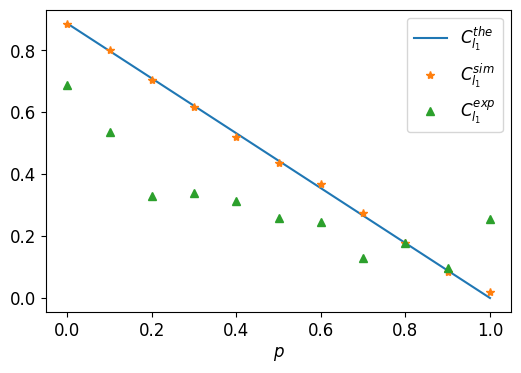

In [106]:
# sem mitigacao, chip quito, qr[1]
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size':12})
plt.figure(figsize = (6,4), dpi = 100)
plt.plot(pt,Ct,label=r'$C_{l_1}^{the}$')
#plt.plot(pt,Pt,label=r'$P_{jb}^{the}$')
plt.plot(p,Csim,'*',label=r'$C_{l_1}^{sim}$')
#plt.plot(p,Psim,'o',label=r'$P_{jb}^{sim}$')
plt.plot(p,Cexp,'^',label=r'$C_{l_1}^{exp}$')
#plt.plot(p,Pexp,'+',label=r'$P_{jb}^{exp}$')
plt.xlabel(r'$p$')
plt.legend()
plt.show()

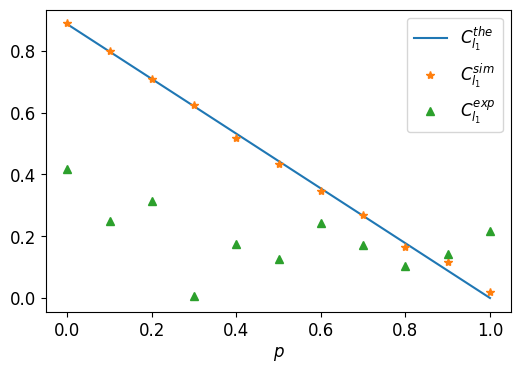

In [92]:
# sem mitigacao, chip belem

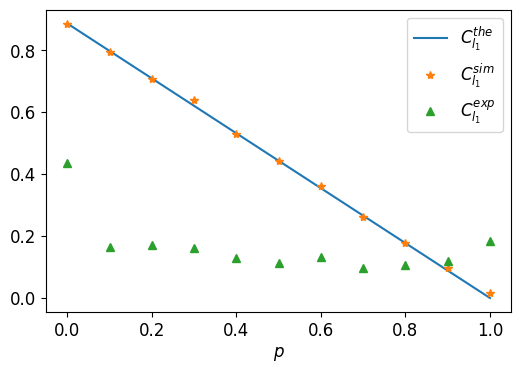

In [77]:
# sem mitigacao, chip manila

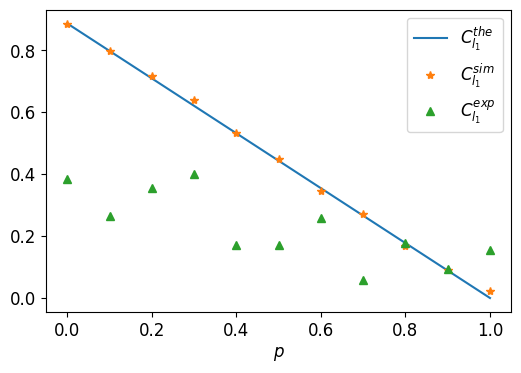

In [53]:
# sem mitigacao, chip quito, qr[0]

In [108]:
f = open("jobs_ids_CS_rho.txt", "w")
f.write(str(jobs_ids))
f.close()

In [1]:
f = open("jobs_ids_CS_rho.txt","r")
list_ids = f.read().replace("'","").replace(" ","").replace("[","").replace("]","").split(",")
f.close()
print(list_ids)

FileNotFoundError: ignored

In [110]:
# error mitigation
qr = QuantumRegister(4); qubit_list = [1]
meas_calibs, state_labels = complete_meas_cal(qubit_list = qubit_list, qr = qr)
job = qiskit.execute(meas_calibs, backend = device, shots = nshots)
print(job.job_id())
job_monitor(job)

63a124fa05888e2fcb99ab6e
Job Status: job has successfully run


In [111]:
job = device.retrieve_job('63a124fa05888e2fcb99ab6e')
meas_fitter = CompleteMeasFitter(job.result(), state_labels)

In [116]:
p = np.arange(0,1.1,0.1); d = len(p)
Cexp = np.zeros(d); Pexp = np.zeros(d)

for j in range(0,d):
    job = device.retrieve_job(list_ids[j])
    mitigated_results = meas_fitter.filter.apply(job.result())
    qstf_exp = StateTomographyFitter(mitigated_results, qstc)
    rho_exp = qstf_exp.fit(method='lstsq')
    Cexp[j] = coh_l1(rho_exp)
    Pexp[j] = predict_jb(rho_exp)

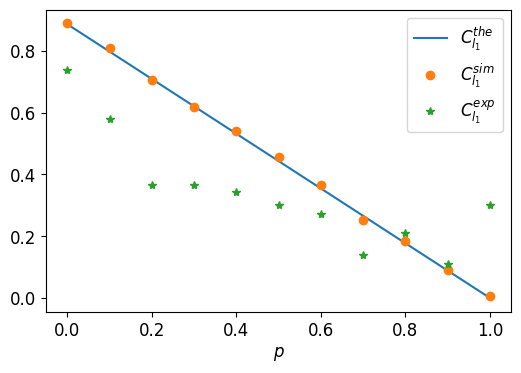

In [120]:
# com mitigacao, chip quito, qr[1]
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size':12})
plt.figure(figsize = (6,4), dpi = 100)
plt.plot(pt,Ct,label=r'$C_{l_1}^{the}$')#,color='green')
plt.plot(p,Csim,'o',label=r'$C_{l_1}^{sim}$')#,color='blue')
plt.plot(p,Cexp,'*',label=r'$C_{l_1}^{exp}$')#,color='orange')
#plt.plot(pt,Pt,label=r'$P_{jb}^{the}$')
#plt.plot(p,Psim,'o',label=r'$P_{jb}^{sim}$')
#plt.plot(p,Pexp,'+',label=r'$P_{jb}^{exp}$')
plt.xlabel(r'$p$')
plt.legend()
plt.savefig('fig_QCS_mixed.pdf')
plt.show()

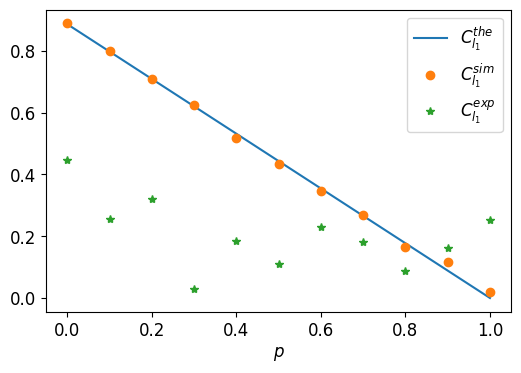

In [98]:
# com mitigacao, chip belem

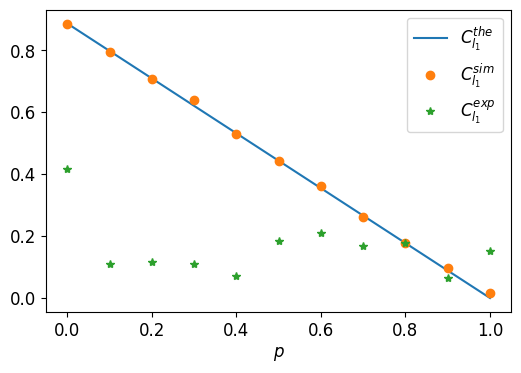

In [84]:
# com mitigacao, chip manila

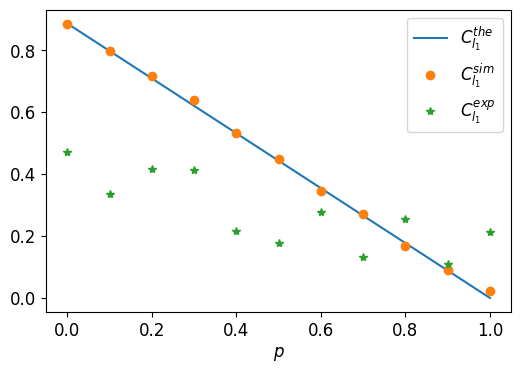

In [69]:
# com mitigacao, chip quito, qr[0]

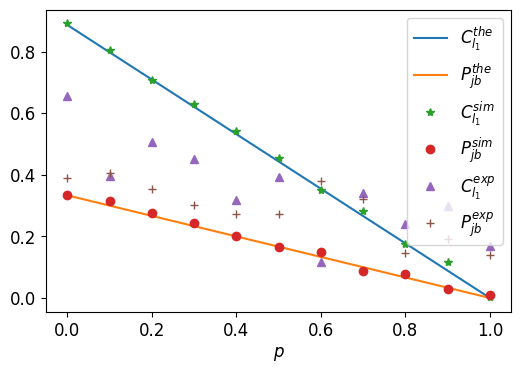

In [31]:
# com mitigacao, chip quito

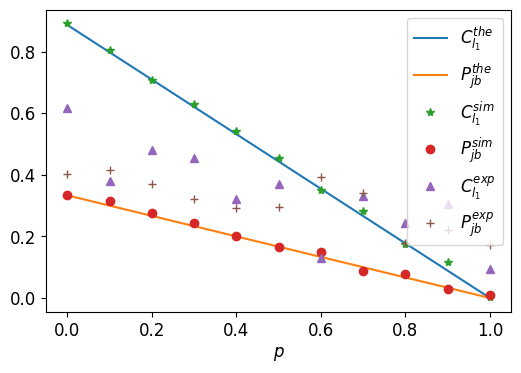

In [23]:
# sem mitigacao, chip quito